In [2]:
import shutil

zip_path = "/content/archive.zip"  # Zip dosyasının konumu
extract_to = "/content/eski-veri-seti-snf-karm"  # Çıkartılacak hedef klasör

shutil.unpack_archive(zip_path, extract_to)

print("✅ Dosya başarıyla çıkartıldı!")


✅ Dosya başarıyla çıkartıldı!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Ana veri dizini ve hedef dizinleri tanımla
base_dir = "/content/eski-veri-seti-snf-karm"
output_dir = "/content/split_dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Oranları belirle
test_size = 0.2

# Mevcut dizinleri temizle ve yeniden oluştur
for folder in [train_dir, test_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Her bir sınıfı ayrı ayrı işle
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Görselleri listele ve train/test olarak ayır
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.jpeg', '.png'))]
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Hedef klasörleri oluştur
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Görselleri ilgili klasörlere KOPYALA
    for img in train_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in test_images:
        shutil.copy2(os.path.join(class_path, img), os.path.join(test_class_dir, img))

print("✅ Veri başarıyla train/test olarak bölündü.")


✅ Veri başarıyla train/test olarak bölündü.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Veri dizinleri
train_dir = "/content/split_dataset/train"
test_dir = "/content/split_dataset/test"
img_size = (224, 224)
batch_size = 64
epochs = 10 # İlk eğitim için epoch sayısı

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 5110 files belonging to 8 classes.
Found 1282 files belonging to 8 classes.


In [10]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50 modelini yükle (transfer öğrenme)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Başlangıçta katmanları dondur

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')  # Sınıf sayısı
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_model.keras', save_best_only=True, monitor='val_accuracy')

# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.4000 - loss: 1.7312 - val_accuracy: 0.5016 - val_loss: 1.2584
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4835 - loss: 1.3411 - val_accuracy: 0.5343 - val_loss: 1.2502
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5043 - loss: 1.2982 - val_accuracy: 0.5413 - val_loss: 1.2139
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5100 - loss: 1.2973 - val_accuracy: 0.5374 - val_loss: 1.2026
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5256 - loss: 1.2685 - val_accuracy: 0.5257 - val_loss: 1.2129
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5233 - loss: 1.2495 - val_accuracy: 0.5507 - val_loss: 1.1923
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.5365 - loss: 1.2274 - val_accuracy: 0.5429 - val_loss: 1.1799
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0

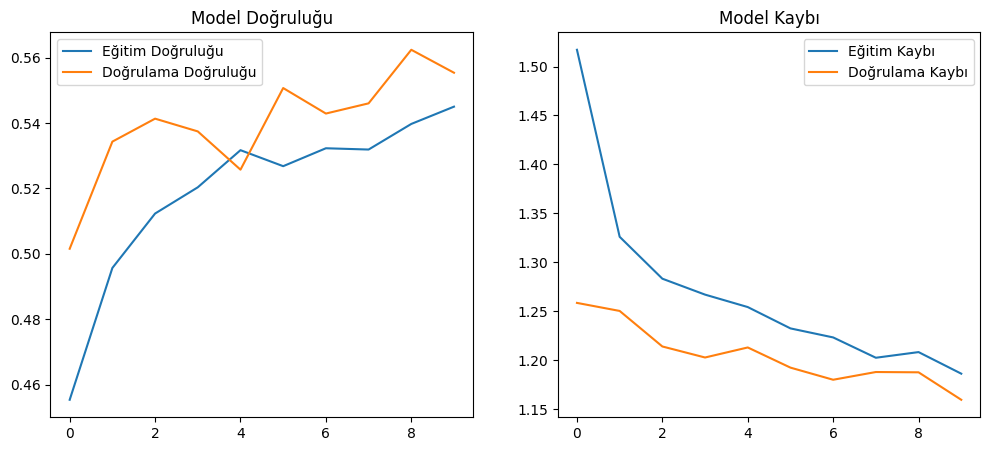

In [11]:
# Sonuçları görselleştir
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.legend()

plt.show()

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Test veri kümesini tahmin et
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    predicted_labels.extend(predicted_classes)
    true_labels.extend(true_classes)

# Performans raporu
unique_classes = sorted(set(true_labels + predicted_labels))
target_names = [str(cls) for cls in unique_classes]
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Confusion matrix
cmp = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", cmp)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.73      0.73      0.73        59
           2

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
